# Relative strength of European football teams' benches

Author: Frédéric DITH  |  Creation date: 2023-11-11  |  Last updated: 2023-11-13

`python`, `pandas`, `plotly-express`, `sklearn`, `data-analytics`,`statistics`

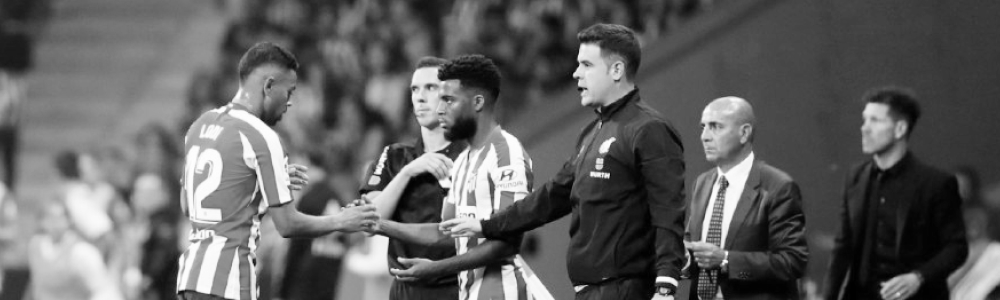

## Context

This self-assigned project is a simple analysis on a dataset of football players. Among all the questions we can try to answer, I set up on trying to understand the contributions of substitute players in each team. Any game starts with 22 players on the field, but substitute players can also create differences. I wanted to find out if this difference could be measured.

## Findings

I was able to create a simple model that calculates the relative strengths of teams' starter and bench players, using data available at player level. You can see the results at the very end of this notebook.

The five highest 'bench' scores were given to:
- Bayern Munich (100.00)
- Atlético Madrid (92.93)
- Newcastle Utd (81.93)
- Brighton (81.45)
- Real Madrid (74.96)

The five highest 'starter' scores were given to:
- Bayern Munich (100.00)
- Leverkusen (89.33)
- Manchester City (77.93)
- Inter (70.99)
- Girona (68.65)

The five players with the highest individual score in the 'bench' category are :
- Mathys Tel (Bayern Munich, MF/FW)
- Leon Bailey (Aston Villa, MF/FW)
- Deniz Undav (Stuttgart, FW)
- Joselu (Real Madrid, FW)
- Darwin Núñez (Liverpool, FW)

## Methodology

- The data was extracted from [fbref](https://fbref.com/en/comps/Big5/stats/players/Big-5-European-Leagues-Stats) and contains statistics for 2,286 players in the 5 major European leagues (England, Germany, France, Italy, Spain) for the ongoing 2023-24 season.
- A `starter` and `bench` value was calculated for each player, using the available information on matches played, minutes played, etc.
- Features: I chose to only use "goals and assists" (marked as `perf_g+a` in the database) as a proxy for "overall contribution". Other measures could be used instead of this one, or in combination with this one, to get a more precise outcome.
- The `perf_g+a` value for each player was divided between `starter` and `bench` according to coefficients calculated earlier, before being added all up, for each team
- The final score is a normalized value (min-max, 0-100 scale)

## Special note

The idea for this project came from the well written [Weekly posts](https://football-observatory.com/-Posts) by the [CIES Football Observatory](https://football-observatory.com/-About-), and I would like to thank them for the inspiration.

# See the results

- A team higher on the chart has more goals and assists coming from its bench players, compared to other teams.
- A team further to the right has more goals and assists coming from its starter players, compared to other teams

In [18]:
# scatter plot
fig = px.scatter(squad2_scaled, x='perf_g+a_starter', y='perf_g+a_bench', text='squad', color='comp', labels={'starter': 'Starter', 'bench': 'Bench'},
                 title='European Teams, according to their relative starter and bench scores')

# Customize layout
fig.update_layout(
    xaxis=dict(title='Starter score'),yaxis=dict(title='Bench score'),height=800,width=800,annotations=[dict(text='All leagues are shown by default. Click on the leagues on the right hand side to show or hide leagues', showarrow=False, x=0, y=1, xref='paper', yref='paper', font=dict(size=12))],
)

fig.update_traces(textposition='middle right')
fig.show()

# 1 Data collection and transformation

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler


In [3]:
# EXTRACT
# All players from the top 5 European leagues
url = 'https://fbref.com/en/comps/Big5/stats/players/Big-5-European-Leagues-Stats'
df = pd.read_html(url)
df = pd.read_html(url)[0]
df.columns = [' '.join(col).strip() for col in df.columns]
df = df.reset_index(drop=True)

# TRANSFORM
# drop the columns we don't need
df = df.drop(columns=['Unnamed: 0_level_0 Rk','Unnamed: 2_level_0 Nation','Unnamed: 6_level_0 Age',
                      'Unnamed: 7_level_0 Born','Unnamed: 37_level_0 Matches'])

# format header names
df.columns = map(lambda x : x.replace("Unnamed: 1_level_0 Player","name").replace("Unnamed: 5_level_0 Comp","comp").replace("Unnamed: 4_level_0 Squad","squad").replace('Unnamed: 3_level_0 Pos','pos').replace("Performance ", "perf_").replace("Expected ", "exp_").replace("Progression ", "prog_").replace("Per 90 Minutes ", "p90_"), df.columns)
df.columns = df.columns.str.lower()

# rename leagues
comp_mapping = {'eng Premier League': 'EN', 'es La Liga': 'ES', 'de Bundesliga': 'DE', 'it Serie A': 'IT', 'fr Ligue 1': 'FR'}
df['comp'] = df['comp'].replace(comp_mapping)

# convert all values to floats except name, pos, comp and squad
columns_to_exclude = ['name', 'pos', 'comp', 'squad']
df[df.columns.difference(columns_to_exclude)] = df[df.columns.difference(columns_to_exclude)].apply(pd.to_numeric, errors='coerce')

df.dropna(inplace=True)


## Who's a starter? Who's a substitute?

The data we are using contains the following information
- matches played (times the player was on the sheet for a game, regardless of if they played or not)
- starts (times the player started a game)
- minutes played (total minutes played, regardless of starting or not)
- playing time 90s (minutes played divided by 90)

None of these values on their own work for the calculation we want to make, so we'll make a new one.
- `starter` is: (minutes played / matches played * starts) / minutes played
- `bench` is (1-starter)

Example:
- Max Aarons has a total minutes played of 883 minutes. He was on the game sheet 11 times, and started 10 times. We're giving him a `starter` value of 0.909 and a `bench` value of 0.009.
- Any of his contributions will be counted towards `starter` with a 0.909 coefficient, and towards `bench` with a 0.009 coefficient

In [4]:
df['starter'] = (df['playing time min'] / df['playing time mp'] * df['playing time starts']) / df['playing time min']
df['bench'] = 1 - df['starter']

### Let's check our team values

In [5]:
squad_df = df.groupby('squad').agg({'starter': 'mean', 'bench': 'mean'}).reset_index()
squad_df.head(10)

,squad,starter,bench
0,Alavés,0.567981,0.432019
1,Almería,0.693791,0.306209
2,Arsenal,0.664557,0.335443
3,Aston Villa,0.578054,0.421946
4,Atalanta,0.599378,0.400622
5,Athletic Club,0.600921,0.399079
6,Atlético Madrid,0.667816,0.332184
7,Augsburg,0.632863,0.367137
8,Barcelona,0.616368,0.383632
9,Bayern Munich,0.627753,0.372247


The numbers we see here can be interpreted as follows:
- a high value for `starter` suggests that the team as a whole relies on the same group of players for its starting line-up, and doesn't give a lot of playing time to its substitutes
- a higher value for `bench` suggests that the team gives distributes the playing time between all players more equally.

We can display the top 10 teams with the higest starter value here: these are the 10 teams in Europe which rely the most on the same group of players.

In [6]:
top_10_starter = squad_df.nlargest(10, 'starter')
top_10_starter

,squad,starter,bench
16,Brighton,0.710030,0.289970
53,Lyon,0.694632,0.305368
1,Almería,0.693791,0.306209
94,Wolfsburg,0.688469,0.311531
56,Mallorca,0.680130,0.319870
18,Cagliari,0.677655,0.322345
70,Osasuna,0.677522,0.322478
44,Lazio,0.677053,0.322947
74,Real Madrid,0.668894,0.331106
58,Manchester Utd,0.668309,0.331691


We can do the same for the teams that give the most play time to their substitutes.

In [7]:
top_10_bench = squad_df.nlargest(10, 'bench')
top_10_bench

,squad,starter,bench
84,Stuttgart,0.516082,0.483918
48,Leverkusen,0.517149,0.482851
15,Brest,0.518270,0.481730
86,Tottenham,0.537371,0.462629
40,Inter,0.549539,0.450461
88,Udinese,0.550949,0.449051
54,M'Gladbach,0.551100,0.448900
35,Girona,0.551662,0.448338
46,Lecce,0.560935,0.439065
33,Genoa,0.561846,0.438154


In [9]:
starter_avg = squad_df['starter'].mean()
bench_avg = squad_df['bench'].mean()
print(f"Average starter value: {starter_avg}  |  Average bench value: {bench_avg}")

Average starter value: 0.6144540235390418  |  Average bench value: 0.3855459764609582


# 2 Calculate scores
We need to split the data according to the starter/bench value for each player, before regrouping the data by team.

Among all the statistics we have at our disposal, we'll only use goals and assists to create our final index, but this should be easy to replicate for any stat line.

We're creating 2 new columns per player:
- `perf_g+a_starter`
- `perf_g+a_bench`


In [10]:
df2=df
df2['perf_g+a_starter'] = df2['perf_g+a'] * df2['starter']
df2['perf_g+a_bench'] = df2['perf_g+a'] * df2['bench']

In [11]:
# find a player by name
player_data = df2[df2['name'] == 'Warren Zaire-Emery']
# player_data

In [12]:
# sums for all teams
squad2 = df2.groupby('squad').agg({'perf_g+a_starter': 'sum', 'perf_g+a_bench': 'sum'}).reset_index()

# bring back the league data
league_mapping = dict(zip(df2['squad'], df2['comp']))
squad2['comp'] = squad2['squad'].map(league_mapping)

# normalize, scale 0-100
numerical_columns = ['perf_g+a_starter','perf_g+a_bench']
scaler = MinMaxScaler(feature_range=(0, 100))
squad2_scaled = squad2.copy()
squad2_scaled[numerical_columns] = scaler.fit_transform(squad2[numerical_columns])


In [19]:
# scatter plot
fig = px.scatter(squad2_scaled, x='perf_g+a_starter', y='perf_g+a_bench', text='squad', color='comp', labels={'starter': 'Starter', 'bench': 'Bench'},
                 title='European Teams, according to their relative starter and bench scores')

# Customize layout
fig.update_layout(
    xaxis=dict(title='Starter score'),
    yaxis=dict(title='Bench score'),
    height=800,width=800,
    annotations=[dict(text='All leagues are shown by default. Click on the leagues on the right hand side to show or hide leagues', showarrow=False, x=0, y=1, xref='paper', yref='paper', font=dict(size=12))],
)

fig.update_traces(textposition='middle right')
fig.show()

### Extra: All teams, ranked by bench score

In [20]:
squad2_scaled_sorted_bench = squad2_scaled.sort_values(by='perf_g+a_bench', ascending=False)
squad2_scaled_sorted_bench

,squad,perf_g+a_starter,perf_g+a_bench,comp
9,Bayern Munich,100.000000,100.000000,DE
6,Atlético Madrid,50.732699,92.933697,ES
67,Newcastle Utd,46.219882,81.937016,EN
16,Brighton,40.872740,81.450824,EN
74,Real Madrid,58.924219,74.960139,ES
...,...,...,...,...
22,Crystal Palace,24.559190,8.959044,EN
21,Clermont Foot,8.907234,5.960210,FR
15,Brest,16.696639,3.998793,FR
37,Heidenheim,33.408934,2.804254,DE


### Extra: All teams, ranked by starter score

In [21]:
squad2_scaled_sorted_starter = squad2_scaled.sort_values(by='perf_g+a_starter', ascending=False)
squad2_scaled_sorted_starter

,squad,perf_g+a_starter,perf_g+a_bench,comp
9,Bayern Munich,100.000000,100.000000,DE
48,Leverkusen,89.336828,41.217067,DE
57,Manchester City,77.934446,43.045035,EN
40,Inter,70.999625,34.415841,IT
35,Girona,68.657379,72.522596,ES
...,...,...,...,...
53,Lyon,6.015708,10.184540,FR
82,Sheffield Utd,4.944253,0.000000,EN
88,Udinese,3.010386,14.858903,IT
38,Hellas Verona,2.043453,18.682885,IT


### Extra: Top 50 players, ranked by their 'bench' absolute value

In [16]:
players = df2[['name', 'pos', 'squad', 'comp', 'perf_g+a_bench']].copy()
players_sorted = players.sort_values(by='perf_g+a_bench', ascending=False)
players_sorted.head(50)

,name,pos,squad,comp,perf_g+a_bench
2143,Mathys Tel,"FW,MF",Bayern Munich,DE,5.000000
147,Leon Bailey,"MF,FW",Aston Villa,EN,4.800000
2227,Deniz Undav,FW,Stuttgart,DE,4.375000
1021,Joselu,FW,Real Madrid,ES,3.769231
1584,Darwin Núñez,FW,Liverpool,EN,3.636364
461,Ángel Correa,"FW,MF",Atlético Madrid,ES,3.555556
2322,Callum Wilson,FW,Newcastle Utd,EN,3.500000
616,Artem Dovbyk,FW,Girona,ES,3.384615
1523,Jacob Murphy,FW,Newcastle Utd,EN,3.200000
211,Andrea Belotti,"FW,DF",Roma,IT,3.000000
